In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# import shap
import numpy as np
import time
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import MaxNLocator
from sklearn.utils import class_weight

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import nvidia_smi

# nvidia_smi.nvmlInit()
# handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
print(tf.__version__)
print(tf.keras.__version__)
# print(keras.__version__)

2.9.2
2.9.0


In [7]:
# fix random seed for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
seed = 85497648
# seed = 963852741
np.random.seed(seed)
random.seed(123)

NUM_PARALLEL_EXEC_UNITS = 4
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS, inter_op_parallelism_threads=2,
                              allow_soft_placement=True, device_count={'CPU': NUM_PARALLEL_EXEC_UNITS})

tf.random.set_seed(123)

sess = tf.compat.v1.Session(config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)

os.environ["KMP_BLOCKTIME"] = "30"

os.environ["KMP_SETTINGS"] = "1"

os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"

# Rest of code follows ...

In [8]:
# extract test data
rlist = np.load('/content/drive/MyDrive/dataset-events/Events_real_Train_data_GAN_50_norm_V3.npz', allow_pickle=True)
X_train = rlist['data']
Train_label = rlist['label']

In [9]:
unique, counts = np.unique(Train_label, return_counts=True)
Cont = dict(zip(unique, counts))
print(Cont)

{0: 43168, 1: 13007}


In [10]:
# X_train = np.load('/content/drive/MyDrive/dataset-events/Real_time_analise_CD2.npy') # load
print(X_train.shape)
print(X_train[0])

print('train:')
print(len(X_train))

scaler = StandardScaler()
# print(scaler.fit(X_train))

# print(scaler.mean_)

for i in range(0,len(X_train)):
    X_train[i] = scaler.fit_transform(X_train[i,:,:])

X_train = X_train[:,:289,:]

print(X_train.shape)
print(X_train[0])

print('train:')
print(len(X_train))

(56175, 289, 24)
[[ 1.          1.1515223   1.0158852  ... -1.          1.29581627
   0.68943962]
 [ 1.          1.25409689  1.19982963 ... -1.          1.23860073
   1.23266057]
 [ 1.          1.39466206  1.13294075 ... -1.          1.2362654
   1.81634718]
 ...
 [ 1.         -1.55847291 -1.93200331 ... -1.         -1.66537995
  -1.82678925]
 [ 1.         -1.87252843 -1.97858664 ... -1.         -1.89424212
  -1.72010704]
 [ 1.         -1.74082773 -2.0180033  ... -1.         -1.99933189
  -1.58399524]]
train:
56175
(56175, 289, 24)
[[ 0.          1.1515223   1.0158852  ...  0.          1.29581627
   0.68943962]
 [ 0.          1.25409689  1.19982963 ...  0.          1.23860073
   1.23266057]
 [ 0.          1.39466206  1.13294075 ...  0.          1.2362654
   1.81634718]
 ...
 [ 0.         -1.55847291 -1.93200331 ...  0.         -1.66537995
  -1.82678925]
 [ 0.         -1.87252843 -1.97858664 ...  0.         -1.89424212
  -1.72010704]
 [ 0.         -1.74082773 -2.0180033  ...  0.        

In [11]:
Y_train = [int(i) for i in Train_label]


# class_weights = dict(zip(np.unique(Y_train), class_weight.compute_class_weight('balanced',
#                                                  np.unique(Y_train),
#                                                  Y_train))) 

# print(class_weights)

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=2)

In [12]:
rlist = np.load('/content/drive/MyDrive/dataset-events/Events_real_Val.npz', allow_pickle=True)
X_val = rlist['data']
Val_label = rlist['label']

In [13]:
# testX = Val_datafreqT[1236]
# print(testX)

In [14]:
# X_val = np.load('/content/drive/MyDrive/dataset-events/ValX_real_time_analise_CD2.npy') # load
print(X_val.shape)
print(X_val[0])

print('val:')
print(len(X_val))

scaler = StandardScaler()

for i in range(0,len(X_val)):
    X_val[i] = scaler.fit_transform(X_val[i,:,:])

X_val = X_val[:,:289,:]

print(X_val.shape)
print(X_val[0])

print('train:')
print(len(X_val))

(12793, 320, 24)
[[59.982045   59.98375    59.981398   ... 59.98425    59.98251558
  59.98251558]
 [59.981227   59.982672   59.98297    ... 59.981057   59.98198725
  59.98198725]
 [59.981343   59.982643   59.984002   ... 59.985394   59.98297075
  59.98297075]
 ...
 [59.989864   59.988856   59.989214   ... 59.989016   59.98892475
  59.98892475]
 [59.990047   59.989517   59.989818   ... 59.989847   59.98913321
  59.98913321]
 [59.989309   59.989572   59.988943   ... 59.987731   59.98879996
  59.98879996]]
val:
12793
(12793, 289, 24)
[[-2.04608934 -1.28502541 -1.95986288 ... -0.97959356 -1.90511268
  -1.90511268]
 [-2.39546307 -1.73452572 -1.38515506 ... -2.17896124 -2.13862688
  -2.13862688]
 [-2.34591863 -1.74661803 -1.00786596 ... -0.54987961 -1.70393688
  -1.70393688]
 ...
 [ 1.48694187  0.48670631  0.21393654 ...  0.39331245  1.68798579
   1.68798579]
 [ 1.31097368  1.08465013  0.66215014 ...  1.14493623  1.48413968
   1.48413968]
 [ 1.01199861  1.43907986  1.17141731 ...  0.94209923

In [15]:
unique, counts = np.unique(Val_label, return_counts=True)
Cont = dict(zip(unique, counts))
print(Cont)

{0: 10792, 1: 2001}


In [16]:
Y_val = [int(i) for i in Val_label]
Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=2)

In [17]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [18]:
batch_size =32 #* tpu_strategy.num_replicas_in_sync
num_classes = 2
nb_epoch = 250

# input image dimensions
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

print(img_rows)
print(img_cols)
print(batch_size)

289
24
32


In [19]:

if K.image_data_format() == 'channels_first':
    trainX_arr = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    valX_arr = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    print('channels_first')
    
else:
    trainX_arr = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    valX_arr = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

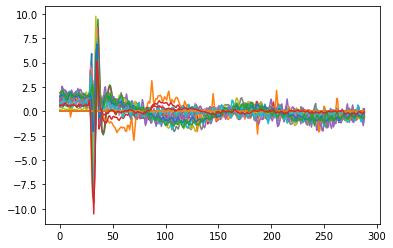

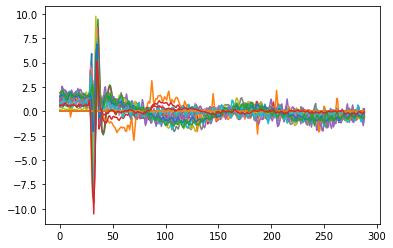

In [20]:
X = trainX_arr[27,:,:,0]

plt.plot(X)
plt.show()


X = X_train[27,:,:]

plt.plot(X)
plt.show()

In [21]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='RMSprop',neuro1=256,neuro2=128,neuro3=128, neuron_drop=100, drop_rate=0.4,dropout_rate_1=0.3,dropout_rate_2=0.4,dropout_rate_3=0.9, momentum=0.55, flag=True, lo=5e-3, decay=1e-7):
    
    model = Sequential()
    model.add(Conv2D(neuro1, kernel_size=(3, 3),
#                      kernel_constraint=constraints.max_norm(3.0),
                     # activation=None,
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu,
                     input_shape=input_shape))
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate_1, seed=66))
    
    model.add(Conv2D(neuro2, kernel_size=(3, 3),
#                      kernel_constraint=constraints.max_norm(3.0),
                     # activation=None,
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))
    # model.add(Activation(tf.nn.relu))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate_2, seed=66))
    
    model.add(Conv2D(neuro3, kernel_size=(3, 3),
#                      kernel_constraint=constraints.max_norm(3.0),
                     # activation=None,
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))
    # model.add(Activation(tf.nn.relu))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate_3, seed=66))
    
    model.add(Flatten())
    
    model.add(Dense(neuron_drop,
#                     kernel_constraint=constraints.max_norm(3.0),
                    kernel_initializer=initializers.glorot_uniform(seed=66),
                    activation=tf.nn.relu))
                    # activation=None
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))
    # model.add(Activation(tf.nn.relu))
    model.add(Dropout(drop_rate, seed=66))
    
    model.add(Dense(num_classes,
                    kernel_initializer=initializers.glorot_uniform(seed=66),
                    # kernel_constraint=constraints.max_norm(2.0),
                    activation=None))
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))
    model.add(Activation('softmax'))

    # print(model.summary())

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=lo, rho=0.99, epsilon=None, decay=decay),
                  # optimizer = optimizer,
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
                  # metrics=['accuracy'])
    
    # plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    return model

In [22]:
# best model
# with tpu_strategy.scope():
model = create_model()


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 287, 22, 256)      2560      
                                                                 
 batch_normalization (BatchN  (None, 287, 22, 256)     1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 144, 11, 256)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 144, 11, 256)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 9, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 142, 9, 128)      5

In [24]:
# from IPython.display import Image
# display(Image('model_plot.png', width=500, height=10))

In [25]:
time_start = time.time()

history = model.fit(trainX_arr,Y_train, epochs=nb_epoch, batch_size=batch_size, verbose=2)
time_elapsed = (time.time() - time_start)

print('elapsed time best model (min):', time_elapsed / 60)


Epoch 1/250
1756/1756 - 95s - loss: 0.2941 - categorical_accuracy: 0.8839 - 95s/epoch - 54ms/step
Epoch 2/250
1756/1756 - 83s - loss: 0.2447 - categorical_accuracy: 0.9029 - 83s/epoch - 47ms/step
Epoch 3/250
1756/1756 - 83s - loss: 0.2321 - categorical_accuracy: 0.9076 - 83s/epoch - 47ms/step
Epoch 4/250
1756/1756 - 83s - loss: 0.2226 - categorical_accuracy: 0.9116 - 83s/epoch - 47ms/step
Epoch 5/250
1756/1756 - 83s - loss: 0.2174 - categorical_accuracy: 0.9133 - 83s/epoch - 47ms/step
Epoch 6/250
1756/1756 - 82s - loss: 0.2116 - categorical_accuracy: 0.9162 - 82s/epoch - 47ms/step
Epoch 7/250
1756/1756 - 82s - loss: 0.2065 - categorical_accuracy: 0.9165 - 82s/epoch - 47ms/step
Epoch 8/250
1756/1756 - 82s - loss: 0.2049 - categorical_accuracy: 0.9173 - 82s/epoch - 47ms/step
Epoch 9/250
1756/1756 - 82s - loss: 0.2026 - categorical_accuracy: 0.9179 - 82s/epoch - 47ms/step
Epoch 10/250
1756/1756 - 82s - loss: 0.1996 - categorical_accuracy: 0.9191 - 82s/epoch - 47ms/step
Epoch 11/250
1756/1

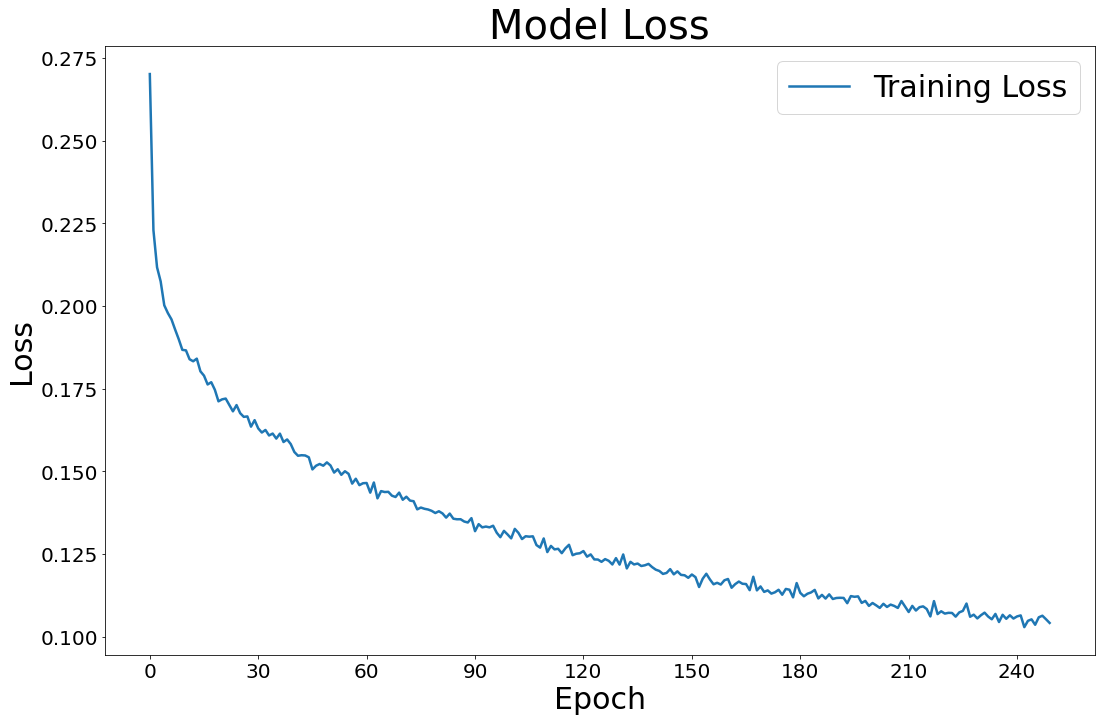

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], linewidth=2.5, label='Training Loss')
plt.legend(loc='best', prop={'size': 30})
plt.title('Model Loss', fontsize=40)
plt.ylabel('Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=30)
ax1 = plt.gca()
plt.tight_layout()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.tick_params(labelsize=20)
plt.show()


In [ ]:
# from keras.models import load_model

# model = load_model('/content/drive/MyDrive/CNN_T_real_time_media_des_atual_reduzido_289.h5')

In [27]:
train_pred = model.predict(trainX_arr, batch_size=1)
train_pred = (train_pred > 0.5).astype(np.int)
train_acc = accuracy_score(Y_train, train_pred)
btrain_acc = balanced_accuracy_score(np.argmax(Y_train, axis=1), np.argmax(train_pred, axis=1))
print('0 1 ')
print(confusion_matrix(np.argmax(Y_train, axis=1), np.argmax(train_pred, axis=1)))
print('Train accuracy:', train_acc)
print('Train balanced accuracy:', btrain_acc)

val_pred = model.predict(valX_arr, batch_size=1)
val_pred = (val_pred > 0.5).astype(np.int)
val_acc = accuracy_score(Y_val, val_pred)
bval_acc = balanced_accuracy_score(np.argmax(Y_val, axis=1), np.argmax(val_pred, axis=1))
bconfusion = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(val_pred, axis=1))
print('0 1')
print(bconfusion)
print('Val accuracy:', val_acc)
print('Val balanced accuracy:', bval_acc)

56175/56175 [==============================] - 111s 2ms/step


<ipython-input-27-e17949272d6f>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_pred = (train_pred > 0.5).astype(np.int)


0 1 
[[37961  5207]
 [   19 12988]]
Train accuracy: 0.9069692923898531
Train balanced accuracy: 0.9389587456201236
12793/12793 [==============================] - 25s 2ms/step
0 1
[[8476 2316]
 [  83 1918]]
Val accuracy: 0.812475572578754
Val balanced accuracy: 0.8719586648484505


<ipython-input-27-e17949272d6f>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_pred = (val_pred > 0.5).astype(np.int)


In [28]:
from sklearn.metrics import precision_score, recall_score

print("Precision Score train : ",precision_score(Y_train, train_pred, 
                                           average=None))
print("recall Score train: ", recall_score(Y_train, train_pred, 
                                           average=None))

print("Precision Score val: ",precision_score(Y_val, val_pred, 
                                           average=None))
print("recall Score val: ", recall_score(Y_val, val_pred, 
                                           average=None))

Precision Score train :  [0.99949974 0.71382248]
recall Score train:  [0.87937824 0.99853925]
Precision Score val:  [0.99030261 0.45299953]
recall Score val:  [0.78539659 0.95852074]


In [26]:
model.save('/content/drive/MyDrive/CNN_T_real_time_GAN_50_only_Train_norm_V2.h5')

# from keras.models import load_model

# model.load_weights('/content/drive/MyDrive/CNN_T_94_81_V_94_78.h5')


In [ ]:
def plot_graf(Train_datafreqT,ev,label,first):
    name_file = '/content/drive/MyDrive/Val_events_V3_FP.html';
    events = list()
    me = list()
    soma = 0
    qtd = 0

    trainXi = Train_datafreqT
    trainXi = pd.DataFrame.from_dict(trainXi)
    
    name_columns = trainXi.columns
    
    for i in range (0,pd.DataFrame.from_dict(trainXi).shape[1]):
        
        y = trainXi.iloc[0:,i].values
       
        trace1 = {

        "fill": "none", 
        "line": {
          "dash": "solid",  
          "shape": "linear", 
          "width": 2
        }, 
        "name": name_columns[i], 
        "type": "scatter",  
        "y": y, 
        "opacity": 1, 
        }

        events.append(trace1)


    # configurar o layout do gráfico
    layout = go.Layout({
      'title': {
          'text': 'Recording r=' + str(ev) + 'Label: '+label,
          'font': {
              'size': 20
          }
      }          
    }

    )


    fig = go.Figure(data=events, layout=layout)
#     fig.show()

    fig_json = fig.to_json()
    
    if(first == True):
        first = False
        template = """<html>
            <head>
                <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            </head>
            <body>
                <div id="""+ str(ev) +"""></div>
                <script>
                    var plotly_data = {}
                    Plotly.react('"""+ str(ev) +"""', plotly_data.data, plotly_data.layout);
                </script>

            """
        with open(name_file, 'a') as f:
            f.write(template.format(fig_json))
    else:
        temp = """<div id="""+ str(ev) +"""></div>
            <script>
                var plotly_data = {}
                Plotly.react('"""+ str(ev) +"""', plotly_data.data, plotly_data.layout);
            </script>"""
        with open(name_file, 'a') as f:
            f.write(temp.format(fig_json))
    return first

In [ ]:
import plotly.graph_objects as go

first = True
for k in range(500,len(val_pred)):
    
    if (np.argmax(val_pred[k],axis=0) == 1) & (np.argmax(Y_val[k],axis=0) == 0):
#         print('pred: ', test_pred[k])
#         print('label: ', Y_test[k])
        
        testXi = pd.DataFrame.from_dict(valX_arr[k, :,:,0])

        first = plot_graf(testXi,k,str(np.argmax(Y_val[k],axis=0)),first)
        

In [ ]:
# for k in range(0,len(train_pred)):
    
#     if (np.argmax(trainX_arr[k],axis=0) == 0) & (np.argmax(Y_train[k],axis=0) == 0):
# #         print('pred: ', test_pred[k])
# #         print('label: ', Y_test[k])
        
#         testXi = pd.DataFrame.from_dict(testX_arr[k, :,:,0])
#         print(testXi.shape)
        
# print(testXi.shape[1])

ValueError: ignored

In [ ]:
import plotly.graph_objects as go
name_file = 'Train_events_L1_p0.html';
first = True



for k in range(0,2400):
    
    if  (np.argmax(test_pred[k],axis=0) == 1) & (np.argmax(Y_test[k],axis=0) == 0):
#         print('pred: ', test_pred[k])
#         print('label: ', Y_test[k])
        
        testXi = pd.DataFrame.from_dict(testX_arr[k, :,:,0])
        testXi = testXi+60
#         testXi.plot(figsize=(15, 10), legend=True)
#         plt.title('Event ev=' + str(k), fontsize=40)
#         plt.show()
        events = list()
   
        for i in range (0,testXi.shape[1]):
            trace1 = {

            "fill": "none", 
            "line": {
              "dash": "solid",  
              "shape": "linear", 
              "width": 2
            }, 
    #         "name": name_columns[i], 
            "type": "scatter",  
            "y": testXi.iloc[0:,i], 
            "opacity": 1, 
            }

            events.append(trace1)


        # configurar o layout do gráfico
        layout = go.Layout({
          'title': {
              'text': 'Event ev=' + str(k),
              'font': {
                  'size': 20
              }
          }          
        }

        )


        fig = go.Figure(data=events, layout=layout)

        fig_json = fig.to_json()

        if(first == True):
            first = False
            template = """<html>
                <head>
                    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
                </head>
                <body>
                    <div id="""+ str(k) +"""></div>
                    <script>
                        var plotly_data = {}
                        Plotly.react('"""+ str(k) +"""', plotly_data.data, plotly_data.layout);
                    </script>

                """
            with open(name_file, 'a') as f:
                f.write(template.format(fig_json))
        else:
            temp = """<div id="""+ str(k) +"""></div>
                <script>
                    var plotly_data = {}
                    Plotly.react('"""+ str(k) +"""', plotly_data.data, plotly_data.layout);
                </script>"""
            with open(name_file, 'a') as f:
                f.write(temp.format(fig_json))




NameError: name 'np' is not defined

In [ ]:

for k in range(0,len(test_pred)):
     if (np.argmax(test_pred[k],axis=1) == 0) & (np.argmax(Y_test[k],axis=1) == 1):
#         print('pred: ', test_pred[k])
#         print('label: ', Y_test[k])
        
        testXi = pd.DataFrame.from_dict(testX_arr[k, :,:,0].T)
        testXi.plot(figsize=(15, 10), legend=True)
        plt.title('Event ev=' + str(k), fontsize=40)
        plt.show()
